<img align="center" src="figures/course.png" width="800">

#                                    16720 (B) Bag of Visual Words - Assignment 2

     Instructor: Kris Kitani                      TAs: Sheng-Yu, Jinkun, Rawal, Arka, Rohan

## Building a Recognition System
We have formed a convenient way to represent images for recognition. We will now produce a basic recognition system with spatial pyramid matching. The goal of the system is presented below,
given an image, classify (\ie recognize/name) the scene where the image was taken. 

<img align="center" src="figures/teaser/teaser.png" width="800">

Traditional classification problems follow two phases: training and testing.
At training time, the computer is given a pile of formatted data (\ie, a collection
of feature vectors) with corresponding labels (\eg, ``desert``, ``kitchen``) and
then builds a model of how the data relates to the labels:
``if green, then kitchen``. At test time, the computer takes features and uses these rules to infer the label:
\eg, ``this is green, therefore it is kitchen``.

In this assignment, we will use the simplest classification model: nearest neighbor.
At test time, we will simply look at the query's nearest neighbor in the training set
and transfer that label. In this example, you will be looking
at the query image and 
looking up its nearest neighbor in a collection of training images whose labels are already known. This approach works
surprisingly well given a huge amount of data, \eg, a very cool graphics applications from [1]. 

The key components of any nearest-neighbor system are: 
* $features$ (how do you represent your instances?)
* $similarity$ (how do you compare instances in the feature space?)

You will implement both in this section.

In [2]:
import nbimporter
import numpy as np
import skimage
import multiprocess
import threading
import queue
import os,time
import math
from ipynb.fs.defs.p1 import get_visual_words

ModuleNotFoundError: No module named 'ipynb'

In [19]:
import nbimporter
import numpy as np
import skimage
import multiprocess
import threading
import queue
import os,time
import math
import scipy.ndimage
import scipy.spatial

In [20]:
def get_visual_words(image, dictionary):
    '''
    Compute visual words mapping for the given image using the dictionary of visual words.

    [input]
    * image: numpy.ndarray of shape (H,W) or (H,W,3)

    [output]
    * wordmap: numpy.ndarray of shape (H,W)
    '''
    '''
    HINTS:
    (1) Use scipy.spatial.distance.cdist to find closest match from dictionary
    (2) Wordmap represents the indices of the closest element (np.argmin) in the dictionary
    '''
    filter_responses = extract_filter_responses(image)
    
    h, w, _ = filter_responses.shape
    filter_responses = np.reshape(filter_responses, [-1, filter_responses.shape[-1]])
    # ----- TODO -----
    
    # YOUR CODE HERE
    distances = scipy.spatial.distance.cdist(filter_responses, dictionary)
    
    min_dist = np.argmin(distances, axis=1)
    wordmap = min_dist.reshape(h, w)
    #  raise NotImplementedError()
    return wordmap
import matplotlib.pyplot as plt

In [22]:
def extract_filter_responses(image):
    '''
    Extracts the filter responses for the given image.

    [input]
    * image: numpy.ndarray of shape (H, W) or (H, W, 3)

    [output]
    * filter_responses: numpy.ndarray of shape (H, W, 3F)
    '''
    
    
    
    if(len(image.shape) == 2):
        image = np.stack((image, image, image), axis=-1)

    if(image.shape == 3 and image.shape[2] == 1):
        image = np.concatenate((image, image, image), axis=-1)

    if(image.shape[2] == 4):
        image = image[:, :, 0:3]

    image = skimage.color.rgb2lab(image)

    filter_responses = []
    '''
    HINTS: 
    1.> Iterate through the scales (5) which can be 1, 2, 4, 8, 8$\sqrt{2}$
    2.> use scipy.ndimage.gaussian_* to create filters
    3.> Iterate over each of the three channels independently
    4.> stack the filters together to (H, W,3F) dim
    '''
    # ----- TODO -----
  #  scales = [1,2,4,8,(8*(2**0.5))]
  #  for i in scales:           #["1","2","4","8","(8/(2**0.5))"]:#scales
  #      for j in range(3):
  #          gaussian = np.append(scipy.ndimage.gaussian_filter(image[:,:,j], sigma=i))
  #          laplacian_of_guassian = np.append(scipy.ndimage.gaussian_laplace(image[:,:,j], sigma=i))
  #          gaussian_x = np.append(scipy.ndimage.gaussian_filter(image[:,:,j], sigma=i, order=(1,0)))
  #          gaussian_y = np.append(scipy.ndimage.gaussian_filter(image[:,:,j], sigma=i, order=(0,1)))
    # YOUR CODE HERE
    for i in [1., 2., 4., 8., (8*2**(0.5))]:
        for j in range(3):
            filter_responses.append((scipy.ndimage.gaussian_filter(image[:,:,j], sigma = i)))
        for j in range(3):
            filter_responses.append((scipy.ndimage.gaussian_laplace(image[:,:,j], sigma = i)))
        for j in range(3):
            filter_responses.append((scipy.ndimage.gaussian_filter(image[:,:,j], sigma = i, order = [0,1])))
        for j in range(3):
            filter_responses.append((scipy.ndimage.gaussian_filter(image[:,:,j], sigma = i, order = [1,0])))
    
    #print(filter_responses[0])
    filter_responses_stacked = np.array(filter_responses[0])
    for i in range(1,60):
        filter_responses_stacked = np.dstack([filter_responses_stacked, filter_responses[i]])   
    
    filter_responses = filter_responses_stacked
    #print(filter_responses.shape)
    #raise NotImplementedError()
    return filter_responses

## For Autograding P2, ensure uploading `trained_system.npz`

### Q2.1 (10 Points -> 5 Autograder + 5 WriteUp)
We will first represent an image with a bag of words approach. In each image, we simply look at
how often each word appears. Write the function
```
            def get_feature_from_wordmap(wordmap,dict_size):
```
that extracts the histogram (Look into ``numpy.histogram()``) of visual words within the given image
(\ie, the bag of visual words). 
As inputs, the function will take:

* $wordmap$ is a $H$ $\times$ $W$ image containing the IDs of the visual words
* $dict\_size$ is the maximum visual word ID (\ie, the number of visual words, the dictionary size). Notice that your histogram should have $dict\_size$ bins, corresponding to how often that each word occurs. 

As output, the function will return $hist$, a $dict\_size$ histogram that is $L_1$ normalized, (i.e., the sum equals $1$).

In [26]:
def get_feature_from_wordmap(wordmap, dict_size):
    '''
    Compute histogram of visual words.

    [input]
    * wordmap: numpy.ndarray of shape (H,W)
    * dict_size: dictionary size K

    [output]
    * hist: numpy.ndarray of shape (K)
    '''
    
    '''
    HINTS:
    (1) We can use np.histogram with flattened wordmap
    '''
    # ----- TODO -----
    # YOUR CODE HERE
    
    hist, _ = np.histogram(wordmap.flatten(), bins=range(dict_size + 1), range=(0, dict_size))
    hist = hist/ np.sum(hist)
    
    #raise NotImplementedError()
    return hist

<font color="blue">**For 5 Images, load visual word maps, visualize their histogram, and include it in the write up.**</font> This will help you verifying that your function is working correctly before proceeding.

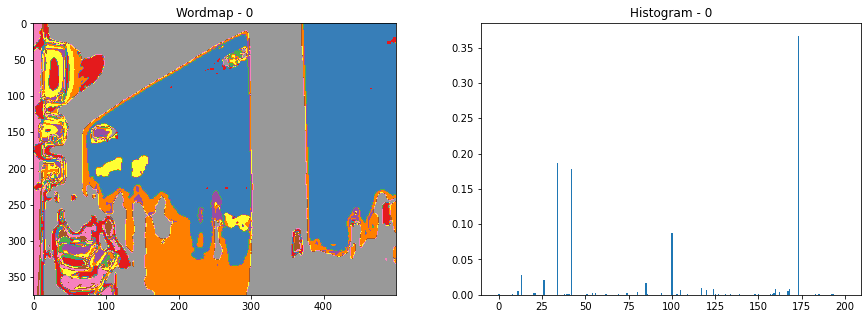

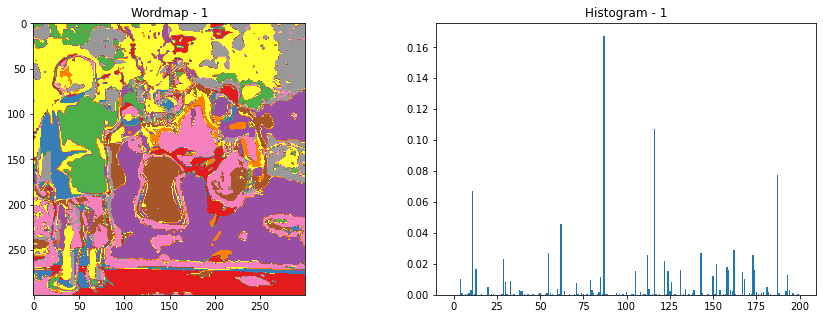

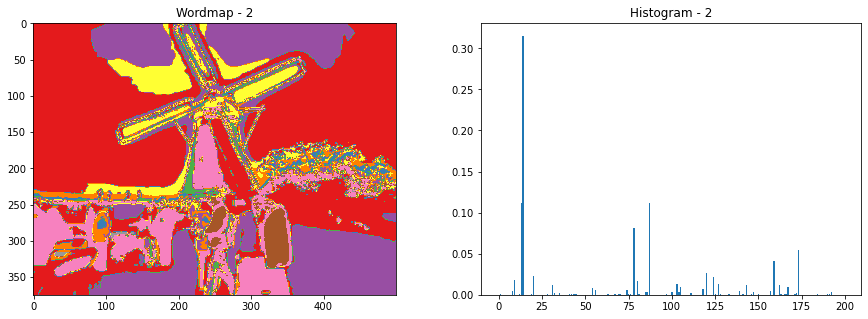

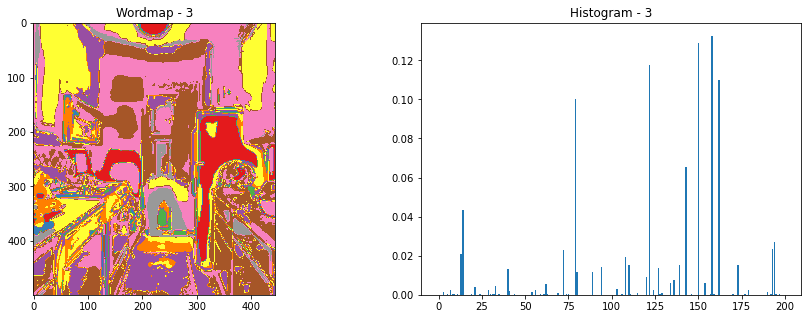

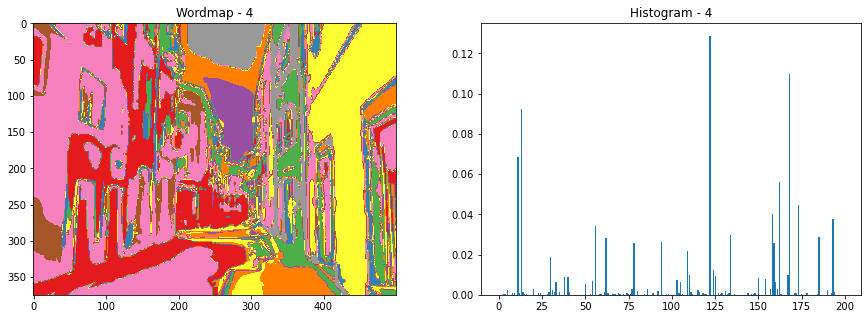

In [32]:
dictionary = np.load('dictionary.npy')
path_img = "./data/aquarium/sun_aairflxfskjrkepm.jpg"
image = skimage.io.imread(path_img)
wordmap = get_visual_words(image, dictionary)

paths = ['./data/aquarium/sun_aadolwejqiytvyne.jpg', './data/aquarium/sun_acjrhiyqadrbtovi.jpg', './data/windmill/sun_bckgfbnkzyricttp.jpg', './data/kitchen/sun_aebceyezzjzyaxcj.jpg', './data/park/labelme_mpjuzxdlazrdgyq.jpg']
#paths = ['./data/aquarium/sun_acjrhiyqadrbtovi.jpg', './data/aquarium/sun_adtiwvbnsxsyohuw.jpg', './data/windmill/sun_acjrhiyqadrbtovi.jpg', './data/kitchen/sun_apccrwjexoyshfqe.jpg', './data/park/labelme_earnkljoflmdqyb.jpg']
dict_size = dictionary.shape[0]

for i, path_img in enumerate(paths):
    image = skimage.io.imread(path_img)
    image = image.astype('float')/ 255.
    wordmap = get_visual_words(image, dictionary)
    hist = get_feature_from_wordmap(wordmap, int(dictionary.shape[0]))
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    axes[0].imshow(wordmap, cmap='Set1')
    axes[0].set_title('Wordmap - {0}'.format(i))
    axes[1].bar(np.arange(dict_size), hist)
    axes[1].set_title('Histogram - {0}'.format(i))
    plt.savefig('plot_2_1_{0}.png'.format(i), pad_inches=0)
    plt.show()

### Multi-resolution: Spatial Pyramid Matching

Bag of words is simple and efficient, but it discards information about the spatial structure of the image and this information is often valuable. One way to alleviate this issue is to use spatial pyramid matching [2]. The general idea is to divide the image into a small number of cells, and concatenate the histogram of each of these cells to the histogram of the original image, with a suitable weight. 

Here we will implement a popular scheme that chops the image into $2^l\times2^l$ cells where $l$ is the layer number. We treat each cell as a small image and count how often each visual word appears. This results in a histogram for every single cell in every layer. Finally to represent the entire image, we concatenate all the histograms together. If there are $L+1$ layers and $K$ visual words, the resulting vector has dimensionality $K\sum_{l=0}^L{4^l} = K\left(4^{(L+1)}-1\right)/3$.

Now comes the weighting scheme. Note that when concatenating all the histograms, histograms from different levels are assigned different weights. Typically (and in the original work [2]), features from layer $l$ gets half the weight of features from layer $l+1$, with the exception of layer 0, which is assigned a weight equal to layer 1. A popular choice is for layer $0$ and layer $1$ the weight is set to $2^{-L}$, and for the rest it is set to $2^{l-L-1}$ (\eg, in a three layer spatial pyramid, $L=2$ and weights are set to $1/4$, $1/4$ and $1/2$ for layer 0, 1 and 2 respectively, see Fig. 7). Take level 2 as an example, there will be 16 histograms in total, each has a norm equal to one. You should concatenate these histograms, normalize this layer (multiply the concatenated vector by 1/16), and apply the 1/2 layer weight of level 2 on top of that. Note that following this operation, concatenating the weighted features of each layer will result in a final vector of norm equal to 1.

<img align="center" src="figures/spm.jpg" width="600">
<figcaption align = "center"><b>Figure 7. Spatial Pyramid Matching: From [2]. Toy example of a pyramid for L = 2. The image has three visual words, indicated by circles, diamonds, and crosses. We subdivide the image at three different levels of resolution. For each level of resolution and each channel, we count the features that fall in each spatial bin. Finally, weight each spatial histogram.}</b></figcaption>

### Q2.2.1 (15 Points Autograder)

Create a function that form a multi-resolution representation of the given image.
```
            def get_feature_from_wordmap_SPM(wordmap,layer_num,dict_size):
```
As inputs, the function will take:

* **layer_num** the number of layers in the spatial pyramid, \ie, $L+1$
* **wordmap** is a $H$ $\times$ $W$ image containing the IDs (\ie index) of the visual words
* **dict_size** is the maximum visual word ID (\ie, the number of visual words, the dictionary size)

As output, the function will return hist_all, a vector that is $L_1$ normalized. **Please use a 3-layer spatial pyramid ($L=2$) for all the following recognition tasks.**

One small hint for efficiency: a lot of computation can be saved if you first compute the histograms of the _finest layer_, because the histograms of coarser layers can then be aggregated from finer ones. Make sure you normalize the histogram after aggregation.

**Note for Autograder :** Ensure that final $hist\_all$ (the output of `get_feature_from_wordmap_SPM`) has histogram features arranged from Loweset Level (global features) to Highest Level (finest features). Example: the output array should **first contain the histogram for Level 0, followed by Level 1, and then Level 2**.

In [28]:
def get_feature_from_wordmap_SPM(wordmap, layer_num, dict_size):
    '''
    Compute histogram of visual words using spatial pyramid matching.

    [input]
    * wordmap: numpy.ndarray of shape (H,W)
    * layer_num: number of spatial pyramid layers
    * dict_size: dictionary size K

    [output]
    * hist_all: numpy.ndarray of shape (K*(4^layer_num-1)/3)
    '''
    '''
    HINTS:
    (1) Take care of Weights 
    (2) Try to build the pyramid in Bottom Up Manner
    (3) the output array should first contain the histogram for Level 0 (top most level) , followed by Level 1, and then Level 2.
    '''
    # ----- TODO -----
    h, w = wordmap.shape
    L = layer_num - 1
    patch_width = math.floor(w / (2**L))
    patch_height = math.floor(h / (2**L))
    
    '''
    HINTS:
    1.> create an array of size (dict_size, (4**(L + 1) -1)/3) )
    2.> pre-compute the starts, ends and weights for the SPM layers L 
    '''
    # YOUR CODE HERE
    
    
    hist_all = np.zeros((dict_size, int((4**(L + 1) - 1) / 3)))
    weights = np.array([2 ** (l - L - 1) / (4 ** l) if l > 1 else 2 ** (-L) / (4 ** l)
                        for l in range(L + 1)])
    index = 0
    starts = np.zeros(L + 1, dtype=np.int16)
    ends = np.zeros(L + 1, dtype=np.int16)
    
    for l in range(L + 1):
        elements_l = 4 ** l
        starts[l] = index
        ends[l] = index + elements_l
        index += elements_l
    
    #raise NotImplementedError()
    '''
    HINTS:
    1.> Loop over the layers from L to 0
    2.> Handle the base case (Layer L) separately and then build over that
    3.> Normalize each histogram separately and also normalize the final histogram
    '''
    # YOUR CODE HERE
    
    for l in range(L + 1):
        patch_w = math.floor(w / (2**l))
        patch_h = math.floor(h / (2**l))
        for i in range(4 ** l):
            h_l = (i // (2 ** l)) * patch_h
            w_l = (i % (2 ** l)) * patch_w
            h_l_end = h_l + patch_h 
            w_l_end = w_l + patch_w
            norm_patch_hist = get_feature_from_wordmap(wordmap[h_l: h_l_end, w_l: w_l_end], dict_size)
            hist_all[:, starts[l] + i] = (norm_patch_hist * weights[l])

    hist_all /= hist_all.sum()
    #raise NotImplementedError()
    return hist_all.flatten()

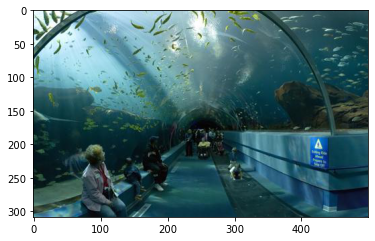

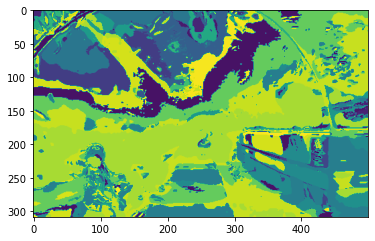

(4200,)
0.0
0.04433495145631068
0.0002380952380952381
0.0016858698267259052
1.0


In [29]:
path_img = "./data/aquarium/sun_aairflxfskjrkepm.jpg"
image = skimage.io.imread(path_img)

dictionary = np.load('dictionary.npy')

wordmap = get_visual_words(image, dictionary)

plt.imshow(image)
plt.show()
plt.imshow(wordmap)
plt.show()

hist_all = get_feature_from_wordmap_SPM(wordmap, 3, dictionary.shape[0])

print(hist_all.shape)
print(hist_all.min())
print(hist_all.max())
print(hist_all.mean())
print(hist_all.std())
print(hist_all.sum())

### 2.3 Comparing images


We will also need a way of comparing images to find the _nearest_ instance in the training data. In this assignment, we'll use the histogram intersection similarity. The histogram intersection similarity between two histograms is the sum of the minimum value of each corresponding bins.

Note that since this is a similarity, you want the $largest$ value to find the _nearest_ instance.

#### Q2.3.1 (10 Points Autograder)
Create the function
```
                def distance_to_set(word_hist,histograms):
```
where $word\_hist$ is a $K\left(4^{(L+1)}-1\right)/3$ vector and $histograms$ is a $T \times K\left(4^{(L+1)}-1\right)/3$ matrix containing $T$ features from $T$ training samples concatenated along the rows. This function returns the histogram intersection similarity between $word\_hist$ and each training sample as a vector of length $T$. Since this is called every time you want to look up a classification, you want this to be fast, so doing a for-loop over tens of thousands of histograms is a very bad idea.

In [30]:
def distance_to_set(word_hist, histograms):
    '''
    Compute similarity between a histogram of visual words with all training image histograms.

    [input]
    * word_hist: numpy.ndarray of shape (K)
    * histograms: numpy.ndarray of shape (N,K)

    [output]
    * sim: numpy.ndarray of shape (N)
    '''
    '''
    HINTS:
    (1) Consider A = [0.1,0.4,0.5] and B = [[0.2,0.3,0.5],[0.8,0.1,0.1]] then \
        similarity between element A and set B could be represented as [[0.1,0.3,0.5],[0.1,0.1,0.1]]   
    '''
    # ----- TODO -----
    # YOUR CODE HERE
    sim = np.sum(np.minimum(word_hist, histograms), axis = 1)
    #raise NotImplementedError()
    return sim

#### Q2.4 Building a Model of the Visual World

Now that we've obtained a representation for each image, and defined a similarity measure to compare two spatial pyramids, we want to put everything up to now together.

You will need to load the training file names from `data/train_data.npz` and the filter bank and visual word dictionary from `dictionary.npy`.
You will save everything to a `.npz` numpy-formated (use `np.savez`) file named `trained_system.npz`. Included will be:


1. $dictionary$: your visual word dictionary.
2. $features$: a $N \times  K\left(4^{(L+1)}-1\right)/3$ matrix containing all of the histograms of the $N$ training images in the data set. A dictionary with $150$ words will make a ``train_features`` matrix of size $1000 \times 3150$.
3. $labels$: an $N$ vector containing the labels of each of the images. ( ``features[i]`` will correspond to label ``labels[i]``).
4. $SPM\_layer\_num$: the number of spatial pyramid layers you used to extract the features for the training images.

We have provided you with the names of the training images in ``data/train_data.npz``.
You want to use the dictionary entry ``image_names`` for training.
You are also provided the names of the test images in ``data/test_data.npz``, which is structured in the same way as the training data; however, _you cannot use the testing images for training._

If it's any helpful, the below table lists the class names that correspond to the label indices:

| 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
|aquarium | park | desert | highway | kitchen | laundromat | waterfall | windmill|

#### Q2.4.1 (15 Points Autograder)
Implement the function
```
                def build_recognition_system():
```
that produces ``trained_system.npz``.

Implement 
```
                def get_image_feature(file_path,dictionary,layer_num,K):
```
that load image, extract word map from the image, compute SPM feature and return the computed feature. Use this function in your ``build_recognition_system()``.

In [31]:
def get_image_feature(file_path, dictionary, layer_num, K):
    '''
    Extracts the spatial pyramid matching feature.

    [input]
    * file_path: path of image file to read
    * dictionary: numpy.ndarray of shape (K,3F)
    * layer_num: number of spatial pyramid layers
    * K: number of clusters for the word maps

    [output]
    * feature: numpy.ndarray of shape (K*(4^layer_num-1)/3)
    '''
    # ----- TODO -----
    # YOUR CODE HERE
    
    import skimage
    from skimage import io
    
    image = io.imread(file_path) 
    image = image.astype('float') / 255.
    wordmap = get_visual_words(image, dictionary)
    
    feature = get_feature_from_wordmap_SPM(wordmap, layer_num, K)
    
    #raise NotImplementedError()
    return [file_path, feature]

In [32]:
from tqdm import tqdm
def build_recognition_system(num_workers=2):
    '''
    Creates a trained recognition system by generating training features from all training images.

    [input]
    * num_workers: number of workers to process in parallel

    [saved]
    * features: numpy.ndarray of shape (N,M)
    * labels: numpy.ndarray of shape (N)
    * dictionary: numpy.ndarray of shape (K,3F)
    * SPM_layer_num: number of spatial pyramid layers
    '''
    
    train_data = np.load("./data/train_data.npz")
    dictionary = np.load("dictionary.npy")
    # ----- TODO -----
    # YOUR CODE HERE
    
    image_names = train_data['files']
    labels = train_data['labels']
    SPM_layer_num = 3
    K = dictionary.shape[0]
    
    num_images = image_names.shape[0]
    ordered_features = np.zeros((num_images, int(K *(4**(SPM_layer_num) -1)/3)))
    
    for i in tqdm(range(num_images)):
        image_path = './data/' + image_names[i]
        _, feature = get_image_feature(image_path, dictionary, SPM_layer_num, K)
        ordered_features[i] = feature

    #raise NotImplementedError()
    np.savez('trained_system.npz', features=ordered_features,
                                    labels=labels,
                                    dictionary=dictionary,
                                    SPM_layer_num=SPM_layer_num)


# NOTE: comment out the lines below before submitting to gradescope
build_recognition_system()

100%|██████████| 1000/1000 [54:02<00:00,  3.24s/it] 


### References

[1]  James Hays and Alexei A Efros. Scene completion using millions of photographs.ACM Transactions onGraphics (SIGGRAPH 2007), 26(3), 2007.

[2]  S. Lazebnik, C. Schmid, and J. Ponce. Beyond bags of features: Spatial pyramid matching for recogniz-ing natural scene categories.  InComputer Vision and Pattern Recognition (CVPR), 2006 IEEE Conferenceon, volume 2, pages 2169–2178, 2006.

[3]  Jian xiong Xiao, J. Hays, K. Ehinger, A. Oliva, and A. Torralba. Sun database: Large-scale scene recogni-tion from abbey to zoo.2010 IEEE Computer Society Conference on Computer Vision and Pattern Recognition,pages 3485–3492, 2010.14